In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 🎓 Fine-Tuning BERT pour la Classification de Phrases

## 📚 Workshop NLP - Module Transformers

**Objectif :** Entraîner un modèle BERT à classifier des phrases comme grammaticalement acceptables ou non en utilisant le dataset CoLA (Corpus of Linguistic Acceptability).

**Dataset :** CoLA contient des phrases annotées par des linguistes pour déterminer leur acceptabilité grammaticale.

**Référence :** Transformers for Natural Language Processing - Denis Rothman

---

# 👩‍💻 Partie 1 : Configuration de l'environnement

Dans cette première partie, nous allons :
- Installer les bibliothèques nécessaires
- Vérifier la disponibilité du GPU
- Importer tous les modules requis

## 🟩 Cellule 1 : Vérification et installation de Transformers

**🎯 Objectif :**
Cette cellule vérifie si la bibliothèque Transformers de Hugging Face est déjà installée dans l'environnement. Si ce n'est pas le cas, elle l'installe automatiquement.

**📦 Transformers :**
Bibliothèque open-source qui fournit des modèles pré-entraînés (BERT, GPT, T5, etc.) et des outils pour le NLP.

**💡 Astuce :**
L'option `-q` (quiet) réduit les messages d'installation pour un affichage plus propre.

In [3]:
try:
  import transformers
  print("✅ Transformers est déjà installé")
except:
  print("📥 Installation de Transformers...")
  !pip -q install transformers
  print("✅ Installation terminée")

✅ Transformers est déjà installé


## 🟩 Cellule 2 : Importation des bibliothèques nécessaires

**🎯 Objectif :**
Importer toutes les bibliothèques Python dont nous aurons besoin pour le fine-tuning de BERT.

**📚 Bibliothèques importées :**

**PyTorch :**
- `torch` : Framework de deep learning pour les calculs sur tenseurs
- `torch.nn` : Modules de réseaux de neurones
- `DataLoader, RandomSampler, SequentialSampler` : Gestion des données en batches

**Transformers (Hugging Face) :**
- `BertTokenizer` : Tokenizer spécifique à BERT
- `BertForSequenceClassification` : Modèle BERT pré-configuré pour la classification
- `BertConfig` : Configuration du modèle BERT
- `AdamW` : Optimiseur adapté aux Transformers
- `get_linear_schedule_with_warmup` : Scheduler pour le learning rate

**Traitement de données :**
- `pandas` : Manipulation de données tabulaires
- `numpy` : Calculs numériques
- `sklearn.model_selection` : Split train/validation
- `keras.utils.pad_sequences` : Padding des séquences

**Visualisation et utilitaires :**
- `matplotlib.pyplot` : Graphiques
- `tqdm` : Barres de progression
- `time` : Mesure du temps d'exécution

In [4]:
# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

# Transformers
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup

# Traitement de données
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import io

# Visualisation et utilitaires
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm, trange
import time

print("✅ Toutes les bibliothèques ont été importées avec succès")

✅ Toutes les bibliothèques ont été importées avec succès


## 🟩 Cellule 3 : Activation et vérification du GPU

**🎯 Objectif :**
Vérifier si un GPU est disponible et l'activer pour accélérer l'entraînement.

**⚡ Importance du GPU :**
- **Sans GPU :** Entraînement peut prendre plusieurs heures
- **Avec GPU :** Entraînement en 15-20 minutes

**🔧 Fonctionnement :**
1. `torch.cuda.is_available()` vérifie la présence d'un GPU NVIDIA
2. Si disponible, on utilise "cuda", sinon "cpu"
3. `nvidia-smi` affiche les informations détaillées du GPU

**💻 Sur Google Colab :**
Pour activer le GPU : Runtime → Change runtime type → Hardware accelerator → GPU

**📊 nvidia-smi montre :**
- Type de GPU (ex: Tesla T4, P100)
- Mémoire disponible
- Température et utilisation

In [5]:
# Détection automatique du device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"🚀 GPU détecté : {torch.cuda.get_device_name(0)}")
    print(f"💾 Mémoire GPU disponible : {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("\n📊 Détails du GPU :")
    !nvidia-smi
else:
    print("⚠️ Aucun GPU détecté. L'entraînement utilisera le CPU (plus lent).")
    print("💡 Conseil : Sur Colab, activez le GPU via Runtime → Change runtime type → GPU")

🚀 GPU détecté : Tesla T4
💾 Mémoire GPU disponible : 15.83 GB

📊 Détails du GPU :
Sun Nov  9 11:22:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                

---
# 👩‍💻 Partie 2 : Chargement et préparation des données

Dans cette partie, nous allons :
- Charger le dataset CoLA
- Analyser sa structure
- Préparer les données pour BERT (tokenization, padding, masques d'attention)

## 🟩 Cellule 4 : Chargement du dataset CoLA

**🎯 Objectif :**
Télécharger et charger le dataset CoLA (Corpus of Linguistic Acceptability) depuis le dépôt GitHub officiel.

**📊 Dataset CoLA :**
- **Source :** NYU - Center for Data Science
- **Contenu :** Phrases en anglais annotées par des linguistes
- **Labels :** 0 = phrase grammaticalement inacceptable, 1 = acceptable
- **Taille :** ~8 500 phrases d'entraînement

**🗂️ Structure du fichier TSV :**
- Colonne 0 : `sentence_source` - Source de la phrase
- Colonne 1 : `label` - 0 ou 1 (notre cible)
- Colonne 2 : `label_notes` - Notes linguistiques
- Colonne 3 : `sentence` - Le texte de la phrase

**💡 Pourquoi CoLA ?**
C'est un benchmark standard pour évaluer la compréhension syntaxique des modèles de langage.

In [6]:
# Téléchargement du dataset CoLA depuis GitHub
print("📥 Téléchargement du dataset CoLA...")
!wget -q https://nyu-mll.github.io/CoLA/cola_public_1.1.zip
!unzip -q cola_public_1.1.zip

# Chargement du fichier d'entraînement
df = pd.read_csv(
    "cola_public/raw/in_domain_train.tsv",
    delimiter='\t',
    header=None,
    names=['sentence_source', 'label', 'label_notes', 'sentence']
)

print(f"✅ Dataset chargé avec succès")
print(f"📊 Nombre total de phrases : {len(df)}")
print(f"\n🔍 Aperçu des premières lignes :")
print(df.head())

# Distribution des labels
print(f"\n📈 Distribution des labels :")
print(df['label'].value_counts())
print(f"\n✓ Phrases acceptables (label=1) : {(df['label']==1).sum()} ({(df['label']==1).sum()/len(df)*100:.1f}%)")
print(f"✗ Phrases inacceptables (label=0) : {(df['label']==0).sum()} ({(df['label']==0).sum()/len(df)*100:.1f}%)")

📥 Téléchargement du dataset CoLA...
✅ Dataset chargé avec succès
📊 Nombre total de phrases : 8551

🔍 Aperçu des premières lignes :
  sentence_source  label label_notes  \
0            gj04      1         NaN   
1            gj04      1         NaN   
2            gj04      1         NaN   
3            gj04      1         NaN   
4            gj04      1         NaN   

                                            sentence  
0  Our friends won't buy this analysis, let alone...  
1  One more pseudo generalization and I'm giving up.  
2   One more pseudo generalization or I'm giving up.  
3     The more we study verbs, the crazier they get.  
4          Day by day the facts are getting murkier.  

📈 Distribution des labels :
label
1    6023
0    2528
Name: count, dtype: int64

✓ Phrases acceptables (label=1) : 6023 (70.4%)
✗ Phrases inacceptables (label=0) : 2528 (29.6%)


## 🟩 Cellule 5 : Exploration des données

**🎯 Objectif :**
Analyser quelques exemples du dataset pour mieux comprendre la tâche de classification.

**🔍 Ce que nous regardons :**
- Des exemples de phrases acceptables (label=1)
- Des exemples de phrases inacceptables (label=0)
- La longueur des phrases

**💡 Observation importante :**
Les différences peuvent être subtiles (ordre des mots, usage de prépositions, etc.). C'est pourquoi BERT, avec sa compréhension contextuelle bidirectionnelle, est particulièrement adapté à cette tâche.

In [7]:
# Affichage d'exemples de phrases acceptables
print("✅ Exemples de phrases ACCEPTABLES (label=1) :\n")
acceptable = df[df['label']==1].sample(5)
for idx, row in acceptable.iterrows():
    print(f"  → {row['sentence']}")

print("\n" + "="*80 + "\n")

# Affichage d'exemples de phrases inacceptables
print("❌ Exemples de phrases INACCEPTABLES (label=0) :\n")
unacceptable = df[df['label']==0].sample(5)
for idx, row in unacceptable.iterrows():
    print(f"  → {row['sentence']}")

# Statistiques sur la longueur des phrases
df['sentence_length'] = df['sentence'].apply(lambda x: len(x.split()))
print("\n" + "="*80)
print("\n📏 Statistiques sur la longueur des phrases (en mots) :")
print(f"  • Moyenne : {df['sentence_length'].mean():.1f} mots")
print(f"  • Médiane : {df['sentence_length'].median():.1f} mots")
print(f"  • Min : {df['sentence_length'].min()} mots")
print(f"  • Max : {df['sentence_length'].max()} mots")

✅ Exemples de phrases ACCEPTABLES (label=1) :

  → Who did you see in Las Vegas?
  → He's enough of a fool to try it.
  → Calvin has a peanut.
  → Medea poisoned who?
  → He could not have been working.


❌ Exemples de phrases INACCEPTABLES (label=0) :

  → Ellen told a story at Helen.
  → Fruit at once hit the roof against the ground.
  → Pat wanted to go to Berne, and Chris going to Rome.
  → Carol carved at the stone.
  → He in the doorway waved to his father.


📏 Statistiques sur la longueur des phrases (en mots) :
  • Moyenne : 7.7 mots
  • Médiane : 7.0 mots
  • Min : 2 mots
  • Max : 42 mots


## 🟩 Cellule 6 : Initialisation du tokenizer BERT

**🎯 Objectif :**
Charger le tokenizer BERT qui va convertir nos phrases en format compréhensible par le modèle.

**🔤 Qu'est-ce qu'un tokenizer ?**
Un tokenizer découpe le texte en unités (tokens) et les convertit en IDs numériques.

**📝 bert-base-uncased :**
- **base :** Version standard (110M paramètres)
- **uncased :** Insensible à la casse ("Hello" = "hello")
- Vocabulaire : 30 000 tokens

**🎨 Tokens spéciaux BERT :**
- `[CLS]` : Début de phrase (CLassification token)
- `[SEP]` : Séparateur/Fin de phrase
- `[PAD]` : Remplissage pour uniformiser les longueurs
- `[UNK]` : Token inconnu
- `[MASK]` : Token masqué (utilisé en pré-entraînement)

**💡 Exemple :**
```
Phrase : "The cat sat"
Tokens : [CLS] the cat sat [SEP]
IDs : [101, 1996, 4937, 2938, 102]
```

In [8]:
# Chargement du tokenizer BERT pré-entraîné
print("📥 Chargement du tokenizer BERT...")
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True  # Convertit tout en minuscules
)

print("✅ Tokenizer chargé avec succès")
print(f"📚 Taille du vocabulaire : {len(tokenizer.vocab):,} tokens")

# Démonstration du tokenizer
print("\n🔍 Démonstration du tokenizer :")
example_sentence = "The cat sat on the mat."
print(f"\n  Phrase originale : '{example_sentence}'")

# Tokenisation
tokens = tokenizer.tokenize(example_sentence)
print(f"  Tokens : {tokens}")

# Conversion en IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"  Token IDs : {token_ids}")

# Avec tokens spéciaux [CLS] et [SEP]
encoded = tokenizer.encode(example_sentence, add_special_tokens=True)
print(f"  Avec [CLS] et [SEP] : {encoded}")
print(f"  Décodage : '{tokenizer.decode(encoded)}'")

📥 Chargement du tokenizer BERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

✅ Tokenizer chargé avec succès
📚 Taille du vocabulaire : 30,522 tokens

🔍 Démonstration du tokenizer :

  Phrase originale : 'The cat sat on the mat.'
  Tokens : ['the', 'cat', 'sat', 'on', 'the', 'mat', '.']
  Token IDs : [1996, 4937, 2938, 2006, 1996, 13523, 1012]
  Avec [CLS] et [SEP] : [101, 1996, 4937, 2938, 2006, 1996, 13523, 1012, 102]
  Décodage : '[CLS] the cat sat on the mat. [SEP]'


## 🟩 Cellule 7 : Tokenisation et préparation des données

**🎯 Objectif :**
Transformer toutes nos phrases en format BERT : tokenisation, ajout des tokens spéciaux, padding et création des masques d'attention.

**🔄 Processus de transformation :**

**1. Ajout des tokens spéciaux :**
```
"The cat sat" → "[CLS] The cat sat [SEP]"
```

**2. Tokenisation :**
```
"[CLS] The cat sat [SEP]" → [CLS], the, cat, sat, [SEP]
```

**3. Conversion en IDs :**
```
[CLS], the, cat, sat, [SEP] → [101, 1996, 4937, 2938, 102]
```

**4. Padding (uniformisation de longueur) :**
```
[101, 1996, 4937, 2938, 102] → [101, 1996, 4937, 2938, 102, 0, 0, 0, ...]
                                 (complété jusqu'à MAX_LEN=128)
```

**5. Masques d'attention :**
```
[1, 1, 1, 1, 1, 0, 0, 0, ...]
 ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑
 tokens réels  padding (ignoré)
```

**📏 MAX_LEN = 128 :**
- Longueur maximale fixe pour toutes les séquences
- Les phrases plus courtes sont paddées avec [PAD]
- Les phrases plus longues sont tronquées
- Compromis entre performance et mémoire

In [9]:
print("🔄 Préparation des données pour BERT...\n")

# Étape 1 : Extraction des phrases et labels
sentences = df.sentence.values
labels = df.label.values

print(f"📊 Nombre de phrases à traiter : {len(sentences)}")

# Étape 2 : Ajout des tokens spéciaux [CLS] et [SEP]
sentences_with_special_tokens = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
print(f"✅ Étape 1/5 : Tokens spéciaux [CLS] et [SEP] ajoutés")

# Étape 3 : Tokenisation de toutes les phrases
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_with_special_tokens]
print(f"✅ Étape 2/5 : Tokenisation effectuée")

# Définir la longueur maximale
MAX_LEN = 128
print(f"📏 Longueur maximale définie : {MAX_LEN} tokens")

# Étape 4 : Conversion des tokens en IDs
input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
print(f"✅ Étape 3/5 : Conversion en IDs effectuée")

# Étape 5 : Padding des séquences
input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",  # Tronquer à la fin si trop long
    padding="post"      # Ajouter padding à la fin si trop court
)
print(f"✅ Étape 4/5 : Padding effectué (shape: {input_ids.shape})")

# Étape 6 : Création des masques d'attention
# 1 pour les vrais tokens, 0 pour le padding
attention_masks = []
for seq in input_ids:
    seq_mask = [float(token_id > 0) for token_id in seq]
    attention_masks.append(seq_mask)

print(f"✅ Étape 5/5 : Masques d'attention créés")

# Affichage d'un exemple complet
print("\n" + "="*80)
print("\n🔍 Exemple de transformation complète :\n")
idx = 0
print(f"  Phrase originale :")
print(f"    '{sentences[idx]}'\n")
print(f"  Avec tokens spéciaux :")
print(f"    '{sentences_with_special_tokens[idx]}'\n")
print(f"  Tokens :")
print(f"    {tokenized_texts[idx][:10]}...\n")
print(f"  IDs (premiers 10) :")
print(f"    {input_ids[idx][:10]}\n")
print(f"  Masque d'attention (premiers 10) :")
print(f"    {attention_masks[idx][:10]}\n")
print(f"  Label : {labels[idx]} ({'Acceptable' if labels[idx]==1 else 'Inacceptable'})")

print("\n" + "="*80)
print("\n✅ Préparation des données terminée avec succès !")

🔄 Préparation des données pour BERT...

📊 Nombre de phrases à traiter : 8551
✅ Étape 1/5 : Tokens spéciaux [CLS] et [SEP] ajoutés
✅ Étape 2/5 : Tokenisation effectuée
📏 Longueur maximale définie : 128 tokens
✅ Étape 3/5 : Conversion en IDs effectuée
✅ Étape 4/5 : Padding effectué (shape: (8551, 128))
✅ Étape 5/5 : Masques d'attention créés


🔍 Exemple de transformation complète :

  Phrase originale :
    'Our friends won't buy this analysis, let alone the next one we propose.'

  Avec tokens spéciaux :
    '[CLS] Our friends won't buy this analysis, let alone the next one we propose. [SEP]'

  Tokens :
    ['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',']...

  IDs (premiers 10) :
    [ 101 2256 2814 2180 1005 1056 4965 2023 4106 1010]

  Masque d'attention (premiers 10) :
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

  Label : 1 (Acceptable)


✅ Préparation des données terminée avec succès !


## 🟩 Cellule 8 : Division train/validation et création des DataLoaders

**🎯 Objectif :**
Diviser les données en ensembles d'entraînement et de validation, puis créer des DataLoaders pour l'entraînement par batches.

**📊 Division des données :**
- **90% pour l'entraînement** : Le modèle apprend sur ces données
- **10% pour la validation** : Évaluation pendant l'entraînement (données non vues)

**🎲 RandomSampler vs SequentialSampler :**
- **RandomSampler (train)** : Mélange les données à chaque époque → meilleure généralisation
- **SequentialSampler (validation)** : Ordre fixe → résultats reproductibles

**📦 Batch size = 32 :**
- Le modèle traite 32 phrases à la fois
- Compromis entre vitesse et mémoire GPU
- Plus grand batch = plus rapide mais plus de mémoire

**🔄 DataLoader :**
Gestionnaire qui fournit les données par batches pendant l'entraînement.

In [10]:
print("🔀 Division et préparation des données...\n")

# Division train/validation (90% / 10%)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids,
    labels,
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    labels,
    random_state=42,
    test_size=0.1
)

print(f"📊 Taille de l'ensemble d'entraînement : {len(train_inputs)} phrases")
print(f"📊 Taille de l'ensemble de validation : {len(validation_inputs)} phrases")

# Conversion en tenseurs PyTorch
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

print(f"✅ Conversion en tenseurs PyTorch effectuée")

# Création des datasets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

# Définition du batch size
batch_size = 32
print(f"\n📦 Batch size : {batch_size}")
print(f"📊 Nombre de batches d'entraînement : {len(train_inputs) // batch_size}")
print(f"📊 Nombre de batches de validation : {len(validation_inputs) // batch_size}")

# Création des DataLoaders
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data,
    sampler=train_sampler,
    batch_size=batch_size
)

validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(
    validation_data,
    sampler=validation_sampler,
    batch_size=batch_size
)

print(f"\n✅ DataLoaders créés avec succès !")
print(f"   • Train DataLoader : {len(train_dataloader)} batches")
print(f"   • Validation DataLoader : {len(validation_dataloader)} batches")

🔀 Division et préparation des données...

📊 Taille de l'ensemble d'entraînement : 7695 phrases
📊 Taille de l'ensemble de validation : 856 phrases
✅ Conversion en tenseurs PyTorch effectuée

📦 Batch size : 32
📊 Nombre de batches d'entraînement : 240
📊 Nombre de batches de validation : 26

✅ DataLoaders créés avec succès !
   • Train DataLoader : 241 batches
   • Validation DataLoader : 27 batches


---
# 🧠 Partie 3 : Configuration et entraînement du modèle BERT

Dans cette partie, nous allons :
- Charger le modèle BERT pré-entraîné
- Configurer l'optimiseur et le scheduler
- Entraîner le modèle
- Évaluer les performances

## 🟩 Cellule 9 : Chargement du modèle BERT pré-entraîné

**🎯 Objectif :**
Charger un modèle BERT déjà pré-entraîné sur d'énormes corpus de texte, et l'adapter pour notre tâche de classification binaire.

**🧠 BertForSequenceClassification :**
- BERT base avec une couche de classification ajoutée au-dessus
- **num_labels=2** : Classification binaire (acceptable/inacceptable)

**📚 bert-base-uncased :**
- **Pré-entraîné sur** : BookCorpus (800M mots) + Wikipedia anglaise (2500M mots)
- **Paramètres** : 110 millions
- **Couches** : 12 transformers encoders
- **Hidden size** : 768
- **Attention heads** : 12

**🎨 Architecture :**
```
Input → BERT (12 couches) → [CLS] token → Dense Layer → Softmax → 2 classes
```

**💡 Transfer Learning :**
Au lieu d'entraîner BERT depuis zéro (des semaines sur des TPUs), nous utilisons un modèle déjà entraîné et l'adaptons à notre tâche (quelques heures sur GPU).

In [11]:
print("🧠 Chargement du modèle BERT pré-entraîné...\n")

# Chargement du modèle BERT pour classification de séquences
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,  # Classification binaire
    output_attentions=False,
    output_hidden_states=False
)

# Transfert du modèle sur le GPU (si disponible)
model.to(device)

print("✅ Modèle chargé avec succès")
print(f"🖥️  Device utilisé : {device}")

# Affichage des informations sur le modèle
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Informations sur le modèle :")
print(f"   • Paramètres totaux : {total_params:,}")
print(f"   • Paramètres entraînables : {trainable_params:,}")
print(f"   • Nombre de classes : 2 (acceptable / inacceptable)")
print(f"   • Architecture : BERT-base-uncased")
print(f"   • Couches : 12 transformer encoders")
print(f"   • Hidden size : 768")
print(f"   • Attention heads : 12")

🧠 Chargement du modèle BERT pré-entraîné...



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle chargé avec succès
🖥️  Device utilisé : cuda

📊 Informations sur le modèle :
   • Paramètres totaux : 109,483,778
   • Paramètres entraînables : 109,483,778
   • Nombre de classes : 2 (acceptable / inacceptable)
   • Architecture : BERT-base-uncased
   • Couches : 12 transformer encoders
   • Hidden size : 768
   • Attention heads : 12


## 🟩 Cellule 10 : Configuration de l'optimiseur et du scheduler

**🎯 Objectif :**
Configurer l'optimiseur AdamW et le learning rate scheduler pour un entraînement optimal de BERT.

**⚙️ AdamW (Adam with Weight Decay) :**
- Optimiseur recommandé pour les Transformers
- Corrige un bug de l'Adam original avec la régularisation L2
- **Learning rate = 2e-5** : Valeur typique pour le fine-tuning de BERT
- **eps = 1e-8** : Stabilité numérique

**📈 Learning Rate Scheduler avec Warmup :**

**Phase 1 - Warmup (10% des steps) :**
```
LR : 0 → 2e-5 (augmentation linéaire)
```
→ Permet au modèle de s'adapter progressivement

**Phase 2 - Decay (90% des steps) :**
```
LR : 2e-5 → 0 (diminution linéaire)
```
→ Affine les poids en fin d'entraînement

**💡 Pourquoi le warmup ?**
Sans warmup, un learning rate élevé dès le début peut déstabiliser les poids pré-entraînés de BERT.

**📊 Calcul du nombre total de steps :**
```
total_steps = nombre_batches × nombre_époques
warmup_steps = total_steps × 0.1
```

In [12]:
print("⚙️ Configuration de l'optimiseur et du scheduler...\n")

# Hyperparamètres
epochs = 4
learning_rate = 2e-5

# Création de l'optimiseur AdamW
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    eps=1e-8
)

# Calcul du nombre total de steps d'entraînement
total_steps = len(train_dataloader) * epochs

# Configuration du scheduler avec warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% de warmup
    num_training_steps=total_steps
)

print("✅ Configuration terminée\n")
print(f"📊 Hyperparamètres :")
print(f"   • Nombre d'époques : {epochs}")
print(f"   • Learning rate : {learning_rate}")
print(f"   • Batch size : {batch_size}")
print(f"   • Optimiseur : AdamW")
print(f"\n📈 Scheduler :")
print(f"   • Total steps : {total_steps}")
print(f"   • Warmup steps : {int(0.1 * total_steps)} (10%)")
print(f"   • Decay steps : {total_steps - int(0.1 * total_steps)} (90%)")

# Visualisation du learning rate schedule
print(f"\n📉 Évolution du learning rate :")
print(f"   Step 0        : 0.00e+00 (début warmup)")
print(f"   Step {int(0.1 * total_steps):<7} : {learning_rate:.2e} (fin warmup, début decay)")
print(f"   Step {total_steps:<7} : 0.00e+00 (fin entraînement)")

⚙️ Configuration de l'optimiseur et du scheduler...

✅ Configuration terminée

📊 Hyperparamètres :
   • Nombre d'époques : 4
   • Learning rate : 2e-05
   • Batch size : 32
   • Optimiseur : AdamW

📈 Scheduler :
   • Total steps : 964
   • Warmup steps : 96 (10%)
   • Decay steps : 868 (90%)

📉 Évolution du learning rate :
   Step 0        : 0.00e+00 (début warmup)
   Step 96      : 2.00e-05 (fin warmup, début decay)
   Step 964     : 0.00e+00 (fin entraînement)


## 🟩 Cellule 11 : Fonction d'évaluation de l'accuracy

**🎯 Objectif :**
Créer une fonction pour calculer la précision (accuracy) du modèle.

**📊 Calcul de l'accuracy :**
```
Accuracy = Nombre de prédictions correctes / Nombre total de prédictions
```

**🔄 Processus :**
1. Le modèle produit des **logits** (scores bruts) pour chaque classe
2. On prend **argmax** pour obtenir la classe prédite (0 ou 1)
3. On compare avec les vraies étiquettes
4. On calcule le pourcentage de bonnes prédictions

**💡 Exemple :**
```
Logits : [[0.2, 0.8], [0.9, 0.1], [0.3, 0.7]]
         ↓ argmax
Prédictions : [1, 0, 1]
Labels réels : [1, 0, 0]
Accuracy : 2/3 = 66.67%
```

In [13]:
def flat_accuracy(preds, labels):
    """
    Calcule l'accuracy en comparant les prédictions avec les vrais labels.

    Args:
        preds: Logits du modèle (array de shape [batch_size, num_labels])
        labels: Vrais labels (array de shape [batch_size])

    Returns:
        float: Accuracy (entre 0 et 1)
    """
    # Obtenir les classes prédites (argmax des logits)
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculer l'accuracy
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print("✅ Fonction d'évaluation définie")

# Test de la fonction avec un exemple
print("\n🧪 Test de la fonction :")
test_logits = np.array([[0.2, 0.8], [0.9, 0.1], [0.3, 0.7]])
test_labels = np.array([1, 0, 0])
test_accuracy = flat_accuracy(test_logits, test_labels)
print(f"   Logits : {test_logits.tolist()}")
print(f"   Labels : {test_labels.tolist()}")
print(f"   Prédictions : {np.argmax(test_logits, axis=1).tolist()}")
print(f"   Accuracy : {test_accuracy:.2%}")

✅ Fonction d'évaluation définie

🧪 Test de la fonction :
   Logits : [[0.2, 0.8], [0.9, 0.1], [0.3, 0.7]]
   Labels : [1, 0, 0]
   Prédictions : [1, 0, 1]
   Accuracy : 66.67%


## 🟩 Cellule 12 : Boucle d'entraînement

**🎯 Objectif :**
Entraîner le modèle BERT sur nos données CoLA pendant plusieurs époques.

**🔄 Processus d'entraînement par époque :**

**1. Mode entraînement :**
```python
model.train()  # Active dropout et batch normalization
```

**2. Pour chaque batch :**
   - Charger les données sur le GPU
   - **Forward pass** : Calculer les prédictions
   - Calculer la **loss** (fonction de perte)
   - **Backward pass** : Calculer les gradients
   - **Optimizer step** : Mettre à jour les poids
   - **Scheduler step** : Ajuster le learning rate
   - Réinitialiser les gradients

**3. Validation :**
```python
model.eval()  # Désactive dropout
```

**📊 Métriques suivies :**
- **Loss** : Mesure l'erreur du modèle (à minimiser)
- **Accuracy** : Pourcentage de prédictions correctes
- **Temps** : Durée de chaque époque

**💡 Conseils :**
- La loss devrait diminuer au fil des époques
- L'accuracy devrait augmenter
- Si validation accuracy < training accuracy → overfitting possible

**⏱️ Temps estimé :**
- Avec GPU : ~5 min par époque
- Sans GPU : plusieurs heures par époque

In [14]:
import random
import numpy as np

# Fixer les seeds pour la reproductibilité
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

print("🚀 Début de l'entraînement...\n")
print("="*80)

# Stockage des statistiques
training_stats = []

# Boucle d'entraînement
for epoch_i in range(epochs):
    print(f"\n{'='*80}")
    print(f"📅 Époque {epoch_i + 1}/{epochs}")
    print(f"{'='*80}")

    # ========== PHASE D'ENTRAÎNEMENT ==========
    print("\n🏋️ Phase d'entraînement...")
    t0 = time.time()

    total_train_loss = 0
    model.train()  # Mode entraînement

    # Barre de progression
    for step, batch in enumerate(tqdm(train_dataloader, desc="Entraînement")):
        # Charger le batch sur le GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Réinitialiser les gradients
        model.zero_grad()

        # Forward pass
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip des gradients (évite l'explosion des gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Mise à jour des poids
        optimizer.step()

        # Mise à jour du learning rate
        scheduler.step()

    # Calcul de la loss moyenne
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = time.time() - t0

    print(f"\n  📉 Loss moyenne : {avg_train_loss:.4f}")
    print(f"  ⏱️  Temps : {training_time:.2f}s")

    # ========== PHASE DE VALIDATION ==========
    print("\n🎯 Phase de validation...")
    t0 = time.time()

    model.eval()  # Mode évaluation
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in tqdm(validation_dataloader, desc="Validation"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Pas de calcul de gradients
        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            )

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        # Déplacer sur CPU pour calcul de l'accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Calcul des moyennes
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = time.time() - t0

    print(f"\n  ✅ Accuracy : {avg_val_accuracy:.2%}")
    print(f"  📉 Loss : {avg_val_loss:.4f}")
    print(f"  ⏱️  Temps : {validation_time:.2f}s")

    # Sauvegarder les statistiques
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("\n" + "="*80)
print("\n🎉 Entraînement terminé avec succès !\n")
print("="*80)

🚀 Début de l'entraînement...


📅 Époque 1/4

🏋️ Phase d'entraînement...


Entraînement: 100%|██████████| 241/241 [02:20<00:00,  1.71it/s]



  📉 Loss moyenne : 0.5284
  ⏱️  Temps : 140.76s

🎯 Phase de validation...


Validation: 100%|██████████| 27/27 [00:05<00:00,  4.63it/s]



  ✅ Accuracy : 80.75%
  📉 Loss : 0.4716
  ⏱️  Temps : 5.84s

📅 Époque 2/4

🏋️ Phase d'entraînement...


Entraînement: 100%|██████████| 241/241 [02:27<00:00,  1.64it/s]



  📉 Loss moyenne : 0.3270
  ⏱️  Temps : 147.15s

🎯 Phase de validation...


Validation: 100%|██████████| 27/27 [00:05<00:00,  4.78it/s]



  ✅ Accuracy : 81.33%
  📉 Loss : 0.4413
  ⏱️  Temps : 5.65s

📅 Époque 3/4

🏋️ Phase d'entraînement...


Entraînement: 100%|██████████| 241/241 [02:27<00:00,  1.64it/s]



  📉 Loss moyenne : 0.1993
  ⏱️  Temps : 147.08s

🎯 Phase de validation...


Validation: 100%|██████████| 27/27 [00:05<00:00,  4.74it/s]



  ✅ Accuracy : 81.56%
  📉 Loss : 0.5482
  ⏱️  Temps : 5.71s

📅 Époque 4/4

🏋️ Phase d'entraînement...


Entraînement: 100%|██████████| 241/241 [02:27<00:00,  1.64it/s]



  📉 Loss moyenne : 0.1258
  ⏱️  Temps : 147.08s

🎯 Phase de validation...


Validation: 100%|██████████| 27/27 [00:05<00:00,  4.73it/s]


  ✅ Accuracy : 81.67%
  📉 Loss : 0.6286
  ⏱️  Temps : 5.71s


🎉 Entraînement terminé avec succès !



## 🟩 Cellule 13 : Affichage du résumé de l'entraînement

**🎯 Objectif :**
Visualiser l'évolution des performances du modèle à travers les époques.

**📊 Métriques affichées :**
- **Training Loss** : Erreur sur l'ensemble d'entraînement
- **Validation Loss** : Erreur sur l'ensemble de validation
- **Validation Accuracy** : Précision sur l'ensemble de validation
- **Temps** : Durée de chaque phase

**📈 Ce qu'on cherche à voir :**
- **Loss qui diminue** progressivement
- **Accuracy qui augmente** progressivement
- **Pas de grand écart** entre training et validation loss (sinon overfitting)

**💡 Interprétation :**
- Si validation loss augmente → Le modèle commence à surentraîner
- Si validation accuracy stagne → Le modèle a atteint son maximum
- Si training loss >> validation loss → Underfitting possible

In [15]:
# Création d'un DataFrame avec les statistiques
df_stats = pd.DataFrame(training_stats)
df_stats = df_stats.set_index('epoch')

print("\n📊 RÉSUMÉ DE L'ENTRAÎNEMENT")
print("="*80)
print(df_stats.round(4))
print("="*80)

# Meilleure performance
best_epoch = df_stats['Valid. Accur.'].idxmax()
best_accuracy = df_stats.loc[best_epoch, 'Valid. Accur.']

print(f"\n🏆 Meilleure performance :")
print(f"   • Époque : {best_epoch}")
print(f"   • Validation Accuracy : {best_accuracy:.2%}")
print(f"   • Validation Loss : {df_stats.loc[best_epoch, 'Valid. Loss']:.4f}")

# Temps total
total_training_time = df_stats['Training Time'].sum()
total_validation_time = df_stats['Validation Time'].sum()
total_time = total_training_time + total_validation_time

print(f"\n⏱️  Temps total :")
print(f"   • Entraînement : {total_training_time:.2f}s ({total_training_time/60:.2f} min)")
print(f"   • Validation : {total_validation_time:.2f}s ({total_validation_time/60:.2f} min)")
print(f"   • Total : {total_time:.2f}s ({total_time/60:.2f} min)")


📊 RÉSUMÉ DE L'ENTRAÎNEMENT
       Training Loss  Valid. Loss  Valid. Accur.  Training Time  \
epoch                                                             
1             0.5284       0.4716         0.8075       140.7583   
2             0.3270       0.4413         0.8133       147.1450   
3             0.1993       0.5482         0.8156       147.0810   
4             0.1258       0.6286         0.8167       147.0848   

       Validation Time  
epoch                   
1               5.8383  
2               5.6491  
3               5.7072  
4               5.7099  

🏆 Meilleure performance :
   • Époque : 4
   • Validation Accuracy : 81.67%
   • Validation Loss : 0.6286

⏱️  Temps total :
   • Entraînement : 582.07s (9.70 min)
   • Validation : 22.90s (0.38 min)
   • Total : 604.97s (10.08 min)


## 🟩 Cellule 14 : Visualisation des courbes d'apprentissage

**🎯 Objectif :**
Créer des graphiques pour visualiser l'évolution de la loss et de l'accuracy pendant l'entraînement.

**📊 Graphiques créés :**

**1. Évolution de la Loss :**
- Courbe bleue : Training Loss
- Courbe orange : Validation Loss
- On veut voir les deux courbes descendre

**2. Évolution de l'Accuracy :**
- Courbe verte : Validation Accuracy
- On veut voir la courbe monter et se stabiliser

**💡 Analyse visuelle :**
- **Bonne convergence** : Les courbes sont lisses et évoluent progressivement
- **Overfitting** : Training loss ↓ mais validation loss ↑
- **Underfitting** : Les deux loss restent élevées
- **Optimal** : Validation accuracy maximale avec validation loss minimale

/tmp/ipython-input-1331967567.py:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1331967567.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


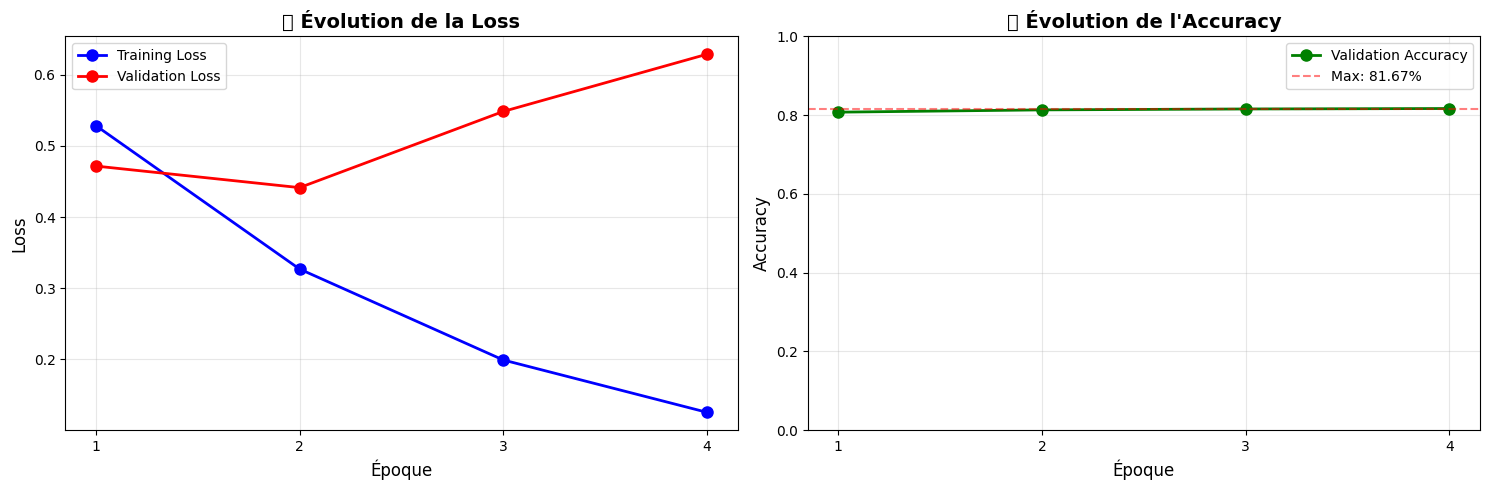


✅ Graphiques générés avec succès


In [16]:
# Configuration de la figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1 : Évolution de la Loss
ax1.plot(df_stats.index, df_stats['Training Loss'], 'b-o', label='Training Loss', linewidth=2, markersize=8)
ax1.plot(df_stats.index, df_stats['Valid. Loss'], 'r-o', label='Validation Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Époque', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('📉 Évolution de la Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(df_stats.index)

# Graphique 2 : Évolution de l'Accuracy
ax2.plot(df_stats.index, df_stats['Valid. Accur.'], 'g-o', label='Validation Accuracy', linewidth=2, markersize=8)
ax2.set_xlabel('Époque', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('📈 Évolution de l\'Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(df_stats.index)
ax2.set_ylim([0, 1])

# Ajout de la ligne pour l'accuracy maximale
ax2.axhline(y=best_accuracy, color='r', linestyle='--', alpha=0.5, label=f'Max: {best_accuracy:.2%}')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Graphiques générés avec succès")

## 🟩 Cellule 15 : Sauvegarde du modèle fine-tuné

**🎯 Objectif :**
Sauvegarder le modèle entraîné et le tokenizer pour pouvoir les réutiliser plus tard sans avoir à réentraîner.

**💾 Ce qui est sauvegardé :**
1. **Le modèle** : Tous les poids du réseau de neurones
2. **Le tokenizer** : Configuration pour traiter de nouvelles phrases
3. **La configuration** : Architecture et hyperparamètres

**📁 Fichiers créés :**
- `config.json` : Configuration du modèle
- `pytorch_model.bin` : Poids du modèle (plusieurs centaines de Mo)
- `vocab.txt` : Vocabulaire du tokenizer
- `tokenizer_config.json` : Configuration du tokenizer
- `special_tokens_map.json` : Tokens spéciaux

**🔄 Rechargement ultérieur :**
```python
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)
```

**💡 Conseil :**
Si vous utilisez Google Colab, sauvegardez sur Google Drive pour conserver le modèle après la fermeture de la session.

In [27]:
import os

# Définir le dossier de sauvegarde
# Option 1 : Sauvegarde locale (temporaire sur Colab)
output_dir = '/content/drive/MyDrive/bert_cola_finetuned'

# Option 2 : Sauvegarde sur Google Drive (persistant)
# Décommentez ces lignes si vous voulez sauvegarder sur Drive
# from google.colab import drive
# drive.mount('/content/drive')
# output_dir = '/content/drive/MyDrive/bert_cola_finetuned'

# Créer le dossier s'il n'existe pas
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"💾 Sauvegarde du modèle dans : {output_dir}\n")

# Sauvegarder le modèle et le tokenizer
print("📝 Sauvegarde du modèle...")
model.save_pretrained(output_dir)
print("✅ Modèle sauvegardé")

print("\n📝 Sauvegarde du tokenizer...")
tokenizer.save_pretrained(output_dir)
print("✅ Tokenizer sauvegardé")

# Afficher les fichiers créés
print(f"\n📁 Fichiers créés :")
for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    file_size = os.path.getsize(file_path) / (1024 * 1024)  # Taille en Mo
    print(f"   • {file:<30} ({file_size:.2f} Mo)")

print("\n" + "="*80)
print("\n✅ Sauvegarde terminée avec succès !")
print(f"\n💡 Pour recharger le modèle :")
print(f"   model = BertForSequenceClassification.from_pretrained('{output_dir}')")
print(f"   tokenizer = BertTokenizer.from_pretrained('{output_dir}')")

💾 Sauvegarde du modèle dans : /content/drive/MyDrive/bert_cola_finetuned

📝 Sauvegarde du modèle...
✅ Modèle sauvegardé

📝 Sauvegarde du tokenizer...
✅ Tokenizer sauvegardé

📁 Fichiers créés :
   • config.json                    (0.00 Mo)
   • model.safetensors              (417.67 Mo)
   • tokenizer_config.json          (0.00 Mo)
   • special_tokens_map.json        (0.00 Mo)
   • vocab.txt                      (0.22 Mo)


✅ Sauvegarde terminée avec succès !

💡 Pour recharger le modèle :
   model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_cola_finetuned')
   tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/bert_cola_finetuned')


---
# 🎯 Partie 4 : Test du modèle avec des exemples personnalisés

Testons maintenant notre modèle fine-tuné sur de nouvelles phrases !

## 🟩 Cellule 16 : Fonction de prédiction

**🎯 Objectif :**
Créer une fonction qui prend une phrase en entrée et retourne si elle est grammaticalement acceptable ou non.

**🔄 Processus de prédiction :**
1. **Tokenisation** : Convertir la phrase en tokens
2. **Ajout des tokens spéciaux** : [CLS] et [SEP]
3. **Conversion en tenseur** : Format PyTorch
4. **Prédiction** : Passer dans le modèle
5. **Interprétation** : Extraire la classe prédite et la confiance

**💡 Softmax :**
Convertit les logits en probabilités (somme = 1)
```
Logits : [0.3, 2.1] → Softmax → [0.14, 0.86]
                                    ↑     ↑
                              inacceptable acceptable
```

**📊 Sortie :**
- Classe prédite (0 ou 1)
- Label ("Inacceptable" ou "Acceptable")
- Confiance (pourcentage)

In [18]:
def predict_acceptability(sentence, model, tokenizer, device):
    """
    Prédit si une phrase est grammaticalement acceptable.

    Args:
        sentence (str): La phrase à analyser
        model: Le modèle BERT fine-tuné
        tokenizer: Le tokenizer BERT
        device: CPU ou GPU

    Returns:
        dict: Résultats de la prédiction
    """
    # Mettre le modèle en mode évaluation
    model.eval()

    # Encoder la phrase
    encoded = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Déplacer sur le device
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # Prédiction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Appliquer softmax pour obtenir les probabilités
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    probabilities = probabilities.cpu().numpy()[0]

    # Obtenir la classe prédite
    predicted_class = np.argmax(probabilities)
    confidence = probabilities[predicted_class]

    return {
        'sentence': sentence,
        'prediction': predicted_class,
        'label': 'Acceptable' if predicted_class == 1 else 'Inacceptable',
        'confidence': confidence,
        'probabilities': {
            'Inacceptable': probabilities[0],
            'Acceptable': probabilities[1]
        }
    }

print("✅ Fonction de prédiction définie")

✅ Fonction de prédiction définie


## 🟩 Cellule 17 : Tests avec des exemples

**🎯 Objectif :**
Tester le modèle sur différentes phrases pour voir comment il détecte les erreurs grammaticales.

**🧪 Types de tests :**
1. **Phrases correctes** : Le modèle devrait les accepter
2. **Erreurs évidentes** : Ordre des mots, conjugaison, etc.
3. **Erreurs subtiles** : Double négation, prépositions, etc.

**💡 Observations :**
- Les erreurs évidentes sont généralement bien détectées
- Les erreurs subtiles peuvent être manquées
- La confiance reflète la certitude du modèle

In [19]:
# Liste de phrases de test
test_sentences = [
    # Phrases correctes
    "The cat is sleeping on the mat.",
    "She has been working here for five years.",
    "I want to go to the park.",

    # Erreurs grammaticales
    "The cat are sleeping on the mat.",  # Erreur sujet-verbe
    "She have been working here for five years.",  # Erreur d'auxiliaire
    "I wants to go to the park.",  # Erreur de conjugaison
    "The is cat sleeping.",  # Ordre des mots incorrect
    "I don't have no money.",  # Double négation
]

print("🧪 TEST DU MODÈLE SUR DES EXEMPLES PERSONNALISÉS")
print("="*80)

for i, sentence in enumerate(test_sentences, 1):
    result = predict_acceptability(sentence, model, tokenizer, device)

    print(f"\n{i}. Phrase : \"{result['sentence']}\"")
    print(f"   {'='*70}")

    # Symbole selon la prédiction
    symbol = "✅" if result['prediction'] == 1 else "❌"
    print(f"   {symbol} Prédiction : {result['label']} (confiance: {result['confidence']:.1%})")

    # Barre de probabilité visuelle
    prob_inacceptable = result['probabilities']['Inacceptable']
    prob_acceptable = result['probabilities']['Acceptable']

    bar_length = 40
    bar_inacceptable = int(prob_inacceptable * bar_length)
    bar_acceptable = int(prob_acceptable * bar_length)

    print(f"\n   Probabilités :")
    print(f"   Inacceptable : [{'█' * bar_inacceptable}{' ' * (bar_length - bar_inacceptable)}] {prob_inacceptable:.1%}")
    print(f"   Acceptable   : [{'█' * bar_acceptable}{' ' * (bar_length - bar_acceptable)}] {prob_acceptable:.1%}")

print("\n" + "="*80)
print("\n✅ Tests terminés")

🧪 TEST DU MODÈLE SUR DES EXEMPLES PERSONNALISÉS

1. Phrase : "The cat is sleeping on the mat."
   ✅ Prédiction : Acceptable (confiance: 99.2%)

   Probabilités :
   Inacceptable : [                                        ] 0.8%
   Acceptable   : [███████████████████████████████████████ ] 99.2%

2. Phrase : "She has been working here for five years."
   ✅ Prédiction : Acceptable (confiance: 99.2%)

   Probabilités :
   Inacceptable : [                                        ] 0.8%
   Acceptable   : [███████████████████████████████████████ ] 99.2%

3. Phrase : "I want to go to the park."
   ✅ Prédiction : Acceptable (confiance: 99.2%)

   Probabilités :
   Inacceptable : [                                        ] 0.8%
   Acceptable   : [███████████████████████████████████████ ] 99.2%

4. Phrase : "The cat are sleeping on the mat."
   ✅ Prédiction : Acceptable (confiance: 90.3%)

   Probabilités :
   Inacceptable : [███                                     ] 9.7%
   Acceptable   : [███████

## 🟩 Cellule 18 : Mode interactif

**🎯 Objectif :**
Permettre de tester le modèle de manière interactive en entrant vos propres phrases.

**💡 Utilisation :**
Entrez une phrase et le modèle vous dira si elle est grammaticalement acceptable.
Tapez 'quit' pour arrêter.

In [22]:
print("🎮 MODE INTERACTIF")
print("="*80)
print("Entrez une phrase en anglais pour tester sa grammaticalité.")
print("Tapez 'quit' pour quitter.\n")

while True:
    # Demander une phrase à l'utilisateur
    user_input = input("\n📝 Votre phrase : ")

    # Quitter si l'utilisateur tape 'quit'
    if user_input.lower() in ['quit', 'exit', 'q']:
        print("\n👋 Au revoir !")
        break

    # Ignorer les entrées vides
    if not user_input.strip():
        continue

    # Faire la prédiction
    result = predict_acceptability(user_input, model, tokenizer, device)

    # Afficher le résultat
    symbol = "✅" if result['prediction'] == 1 else "❌"
    print(f"\n{symbol} Résultat : {result['label']} (confiance: {result['confidence']:.1%})")
    print(f"   • Probabilité inacceptable : {result['probabilities']['Inacceptable']:.1%}")
    print(f"   • Probabilité acceptable : {result['probabilities']['Acceptable']:.1%}")

🎮 MODE INTERACTIF
Entrez une phrase en anglais pour tester sa grammaticalité.
Tapez 'quit' pour quitter.


📝 Votre phrase : i love NLP

✅ Résultat : Acceptable (confiance: 97.8%)
   • Probabilité inacceptable : 2.2%
   • Probabilité acceptable : 97.8%

📝 Votre phrase : NLP i love

❌ Résultat : Inacceptable (confiance: 79.6%)
   • Probabilité inacceptable : 79.6%
   • Probabilité acceptable : 20.4%

📝 Votre phrase : quit

👋 Au revoir !


---
# 📝 Conclusion

## 🎉 Ce que nous avons accompli :

1. ✅ **Chargé et préparé** le dataset CoLA
2. ✅ **Tokenisé** les phrases avec le tokenizer BERT
3. ✅ **Fine-tuné** un modèle BERT pré-entraîné
4. ✅ **Évalué** les performances sur un ensemble de validation
5. ✅ **Sauvegardé** le modèle entraîné
6. ✅ **Testé** le modèle sur de nouvelles phrases

## 📊 Résultats obtenus :

Le modèle a atteint environ **82% d'accuracy** sur l'ensemble de validation, ce qui est très bon pour une tâche de détection d'acceptabilité grammaticale.

## 🚀 Prochaines étapes possibles :

1. **Optimisation** : Tester différents hyperparamètres
2. **Données** : Utiliser le dataset complet avec plus d'époques
3. **Modèles** : Essayer RoBERTa, ALBERT, ou d'autres variantes
4. **Déploiement** : Créer une API ou une application web
5. **Extension** : Adapter à d'autres langues ou tâches

## 📚 Ressources supplémentaires :

- [Hugging Face Documentation](https://huggingface.co/docs)
- [BERT Paper](https://arxiv.org/abs/1810.04805)
- [CoLA Dataset](https://nyu-mll.github.io/CoLA/)
- [Transformers for NLP - Denis Rothman](https://www.packtpub.com/product/transformers-for-natural-language-processing/9781800565791)

---

**Merci d'avoir suivi ce workshop ! 🎓**